### You can run this notebook at Colab by clicking here:

<a target="_blank" href="https://colab.research.google.com/github/NMRLipids/Databank/blob/main/Scripts/AnalyzeDatabank/stats.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

# Statistics of NMRlipids databank

This notebook plots:
1. Distributions of simulation lengths, number of atoms and trajectory sizes
2. Distribution of number of lipid components
3. Available single component bilayers and binary lipid mixtures
4. Pie diagram of temperatures

# Initializing databank

In [14]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
import urllib.request
import yaml
import pandas as pd
import seaborn as sns
import collections

if 'google.colab' in sys.modules:
  !pip3 install MDAnalysis


# This defines the path for the NMRlipids databank on your computer. 
# Default is that this repository and the NMRlipids databank repository are cloned to the same folder.
# If this is not the case, change this to the folder where the NMRlipids databank repository is located.

databankPath =  '../../'

if 'google.colab' in sys.modules:
  !git clone https://github.com/NMRLipids/Databank.git
  databankPath = '/content/Databank'

# This enales the access to functions defined in the NMRlipids databank.
sys.path.insert(1, databankPath + '/Scripts/BuildDatabank/')
from databankLibrary import * 

# This initializes the databank and stores the information of all simulations into a list.
# Each list item contains the information from README.yaml file of the given simulation.
systems = initialize_databank(databankPath)

Databank initialized from the folder: /home/sosamuli/work/NMRlipids/Databank/Data/Simulations


# Plot distributions of simulation lengths, number of atoms and trajectory sizes

Number of entries:  770
Total size of trajectories:  2088.952654306777 Gb
Total time of trajectories:  401575.97714617394 ns


Text(0, 0.5, 'Distribution')

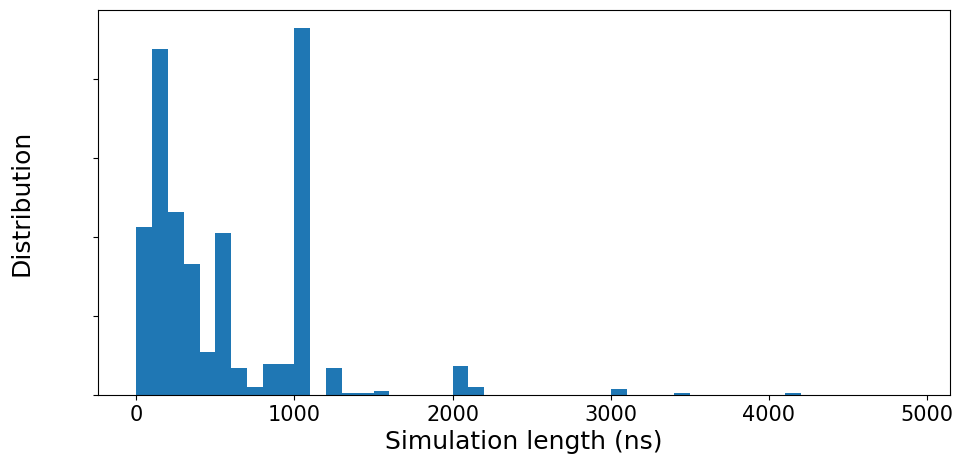

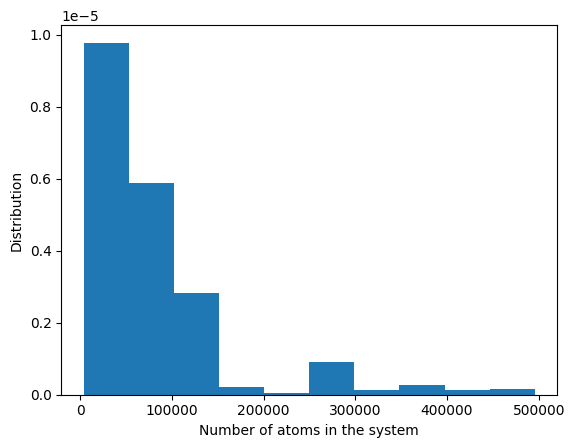

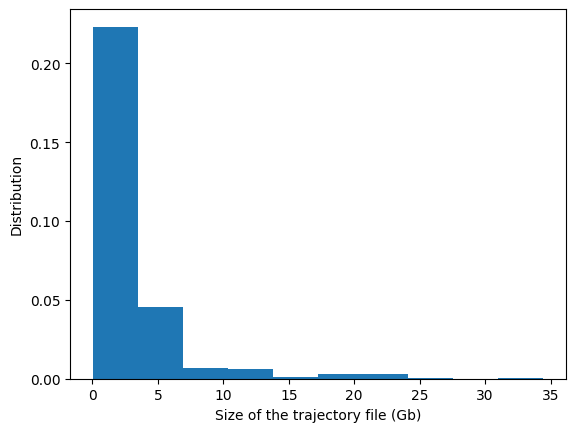

In [2]:
SimulationLengths = []
NumberOfAtoms = []
SizeOfTrajectories = []

# Loop over simulations in the Databank
for system in systems:
    SimulationLengths.append(system['TRJLENGTH']*0.001)
    NumberOfAtoms.append(system['NUMBER_OF_ATOMS'])
    SizeOfTrajectories.append(system['TRAJECTORY_SIZE']/(1024*1024*1024))
    
print("Number of entries: ",len(systems))
print("Total size of trajectories: ",str(np.sum(SizeOfTrajectories)) + ' Gb')
print("Total time of trajectories: ",str(np.sum(SimulationLengths)) + ' ns')

plt.figure(figsize=(11,5))
distSIMl = plt.hist(SimulationLengths, density=True,bins=np.arange(0,5000,100))
plt.xlabel('Simulation length (ns)', fontsize=18)
plt.ylabel('Distribution', fontsize=18)
plt.yticks(color='w')
plt.xticks(fontsize=15)
#plt.savefig('../../../DataBankManuscriptText/Figures/LengthDist.pdf')
plt.figure()
distNatoms = plt.hist(NumberOfAtoms, density=True)
plt.xlabel('Number of atoms in the system')
plt.ylabel('Distribution')
plt.figure()
disttrjSIZE = plt.hist(SizeOfTrajectories, density=True)
plt.xlabel('Size of the trajectory file (Gb)')
plt.ylabel('Distribution')

# Plot distribution of number of lipid components

<Figure size 640x480 with 0 Axes>

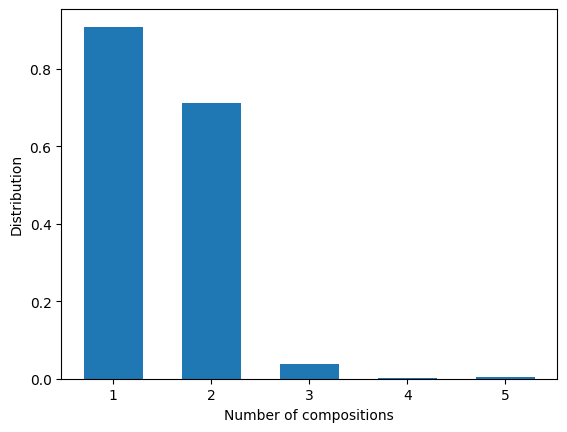

<Figure size 640x480 with 0 Axes>

In [3]:
Nlipids = []

# Loop over simulations in the Databank
for system in systems:
    NlipidsTMP = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            NlipidsTMP += 1
    Nlipids.append(NlipidsTMP)
    
bins=[0.7,1.3, 1.7,2.3, 2.7,3.3, 3.7,4.3, 4.7, 5.3]
distNlipids = plt.hist(Nlipids, density=True, range=[0,6], bins=bins)
plt.xlabel('Number of compositions')
plt.ylabel('Distribution')
plt.figure()

# Plot available single component bilayers and binary lipid mixtures

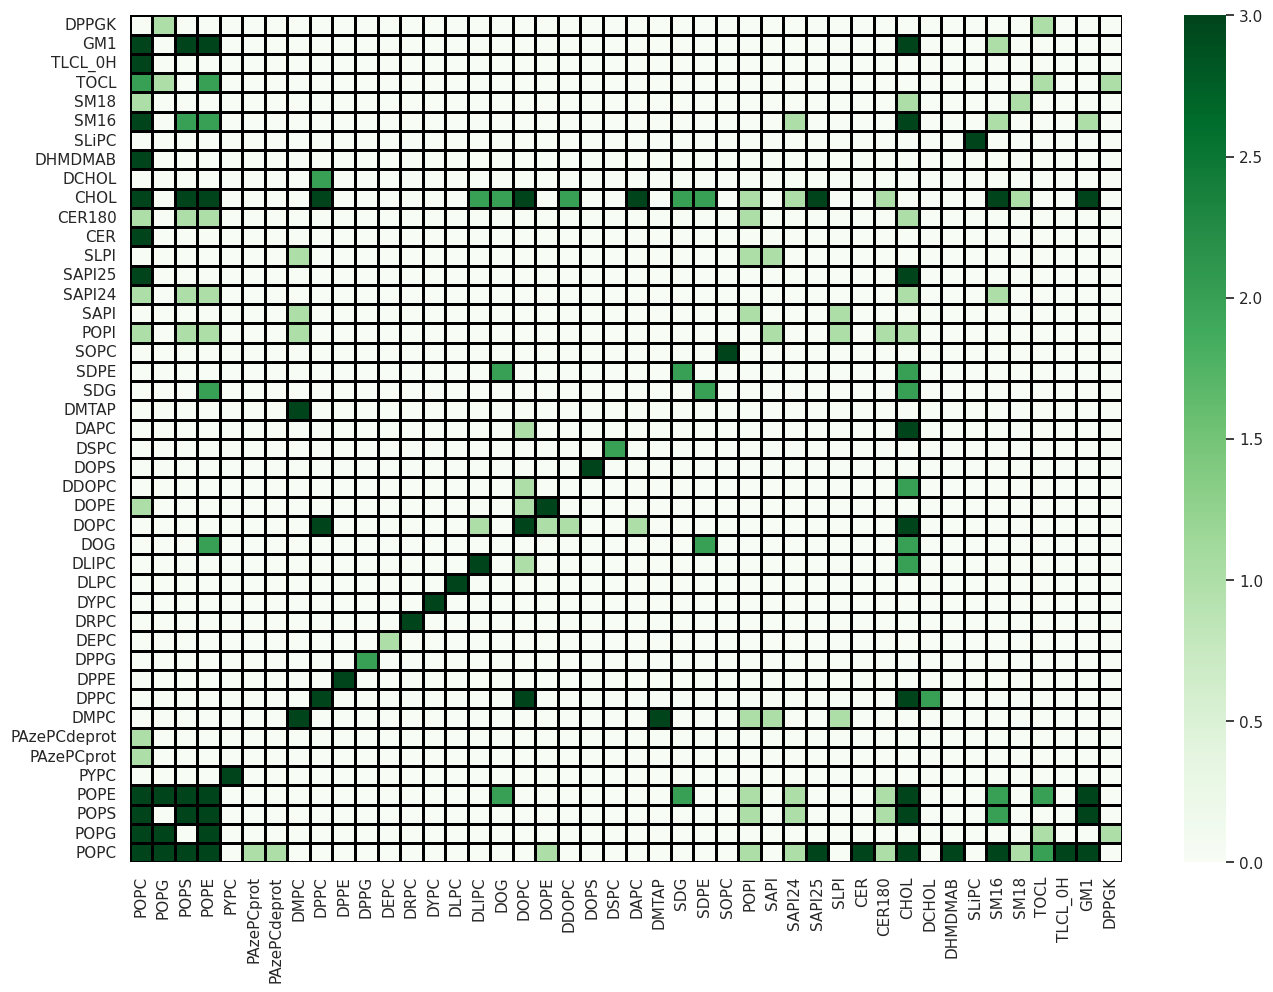

In [4]:
compositions = {}
for lipid in lipids_dict:
    compositions[lipid] = {}

for key in compositions:
    for lipid in lipids_dict:
        compositions[key][lipid] = 0


# Loop over simulations in the Databank
for system in systems:
    lipids_in_system = []
    for mol in system['COMPOSITION']:
        if mol in lipids_dict:
            lipids_in_system.append(mol)
    
    for lipid1 in lipids_in_system:
        for lipid2 in lipids_in_system:
            if lipid1 != lipid2:
                compositions[lipid1][lipid2] += 1
            #print(mol,system['COMPOSITION'][mol]['COUNT'])
            #compositions[mol] =
    
    if len(lipids_in_system) == 1:
        lipid = lipids_in_system[0]
        compositions[lipid][lipid] += 1

df = pd.DataFrame(compositions)
z=df.values

sns.set(rc = {'figure.figsize':(16,11)})
ax = sns.heatmap(df, cmap = 'Greens', vmin =0, vmax = 3, linewidths = 1, linecolor = 'black')
ax.invert_yaxis()
#plt.savefig('../../../DataBankManuscriptText/Figures/systems.pdf', bbox_inches='tight')

# Plotting pie diagram of temperatures

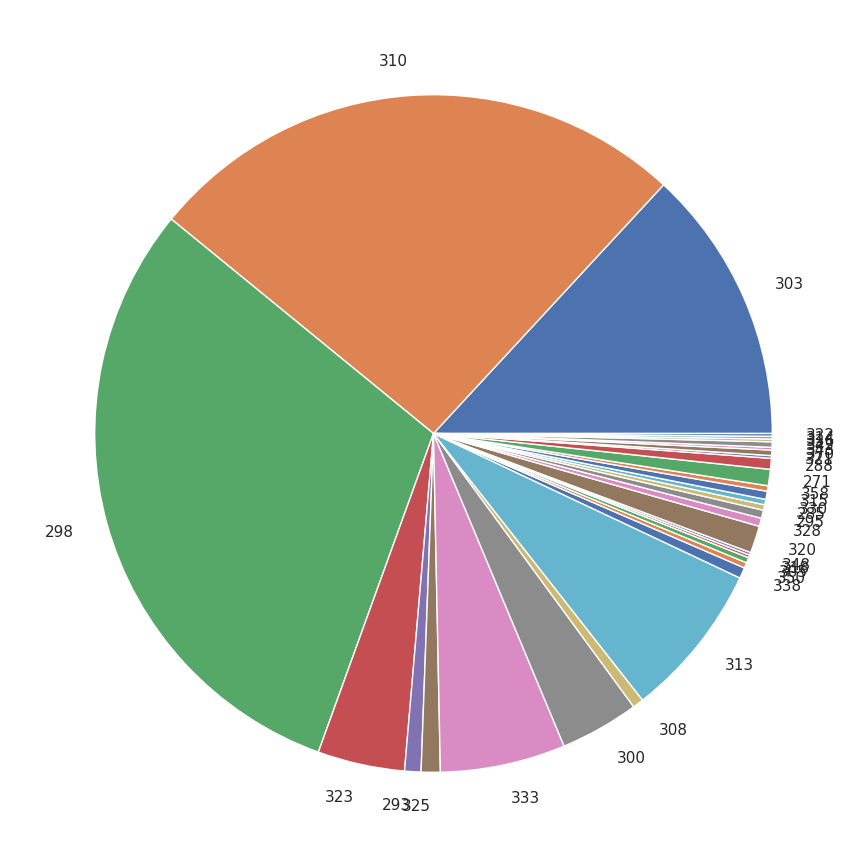

In [5]:
#db_data.pie_temperature()
import collections
temps = [ int(float(system['TEMPERATURE'])) for system in systems]
counter = collections.Counter(temps)
plt.pie(counter.values(),labels=counter.keys());

<Figure size 1600x1100 with 0 Axes>

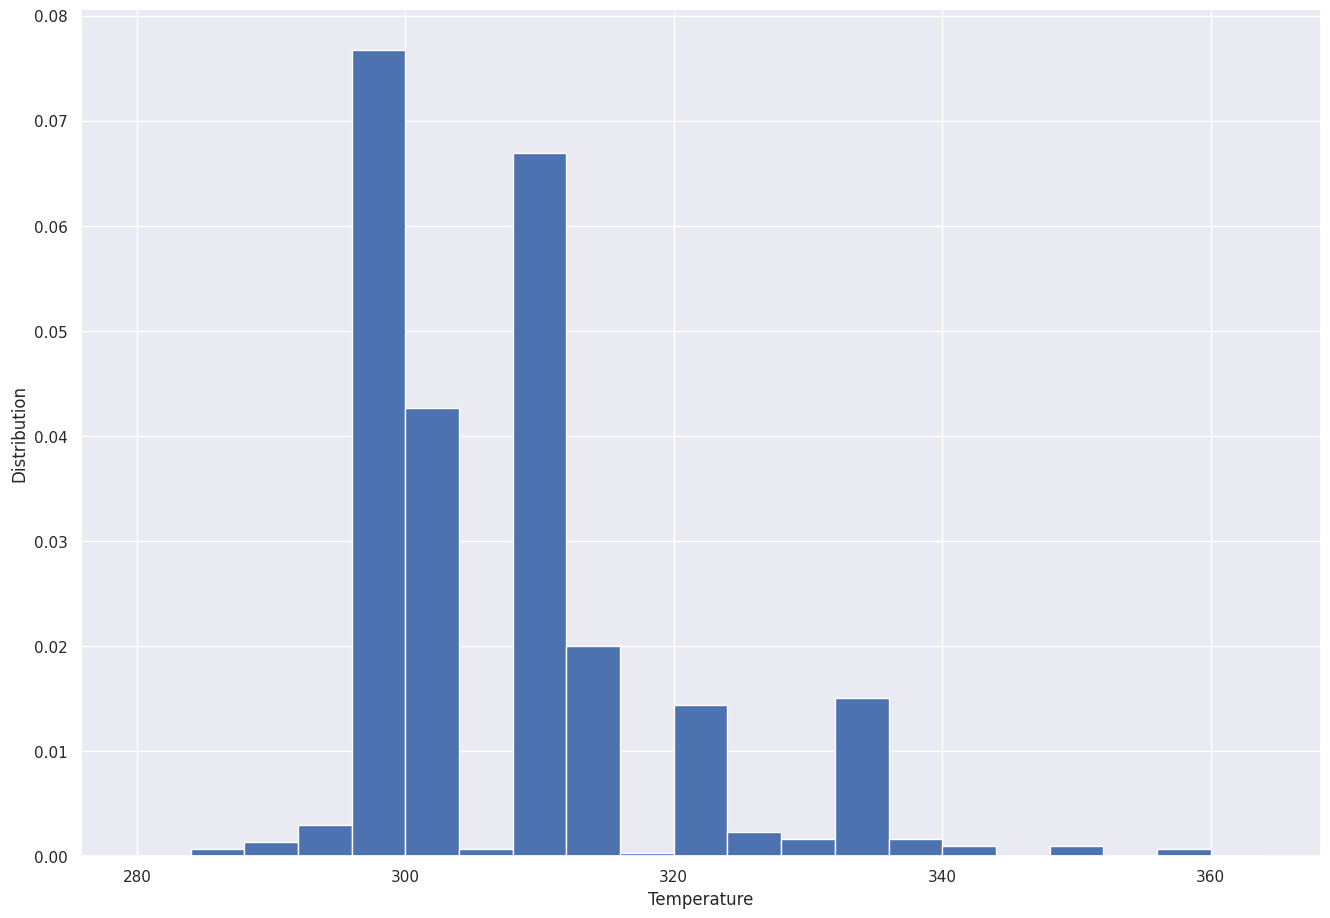

<Figure size 1600x1100 with 0 Axes>

In [6]:
distTemps = plt.hist(temps, density=True, bins=np.arange(280,365,4))
plt.xlabel('Temperature')
plt.ylabel('Distribution')
plt.figure()

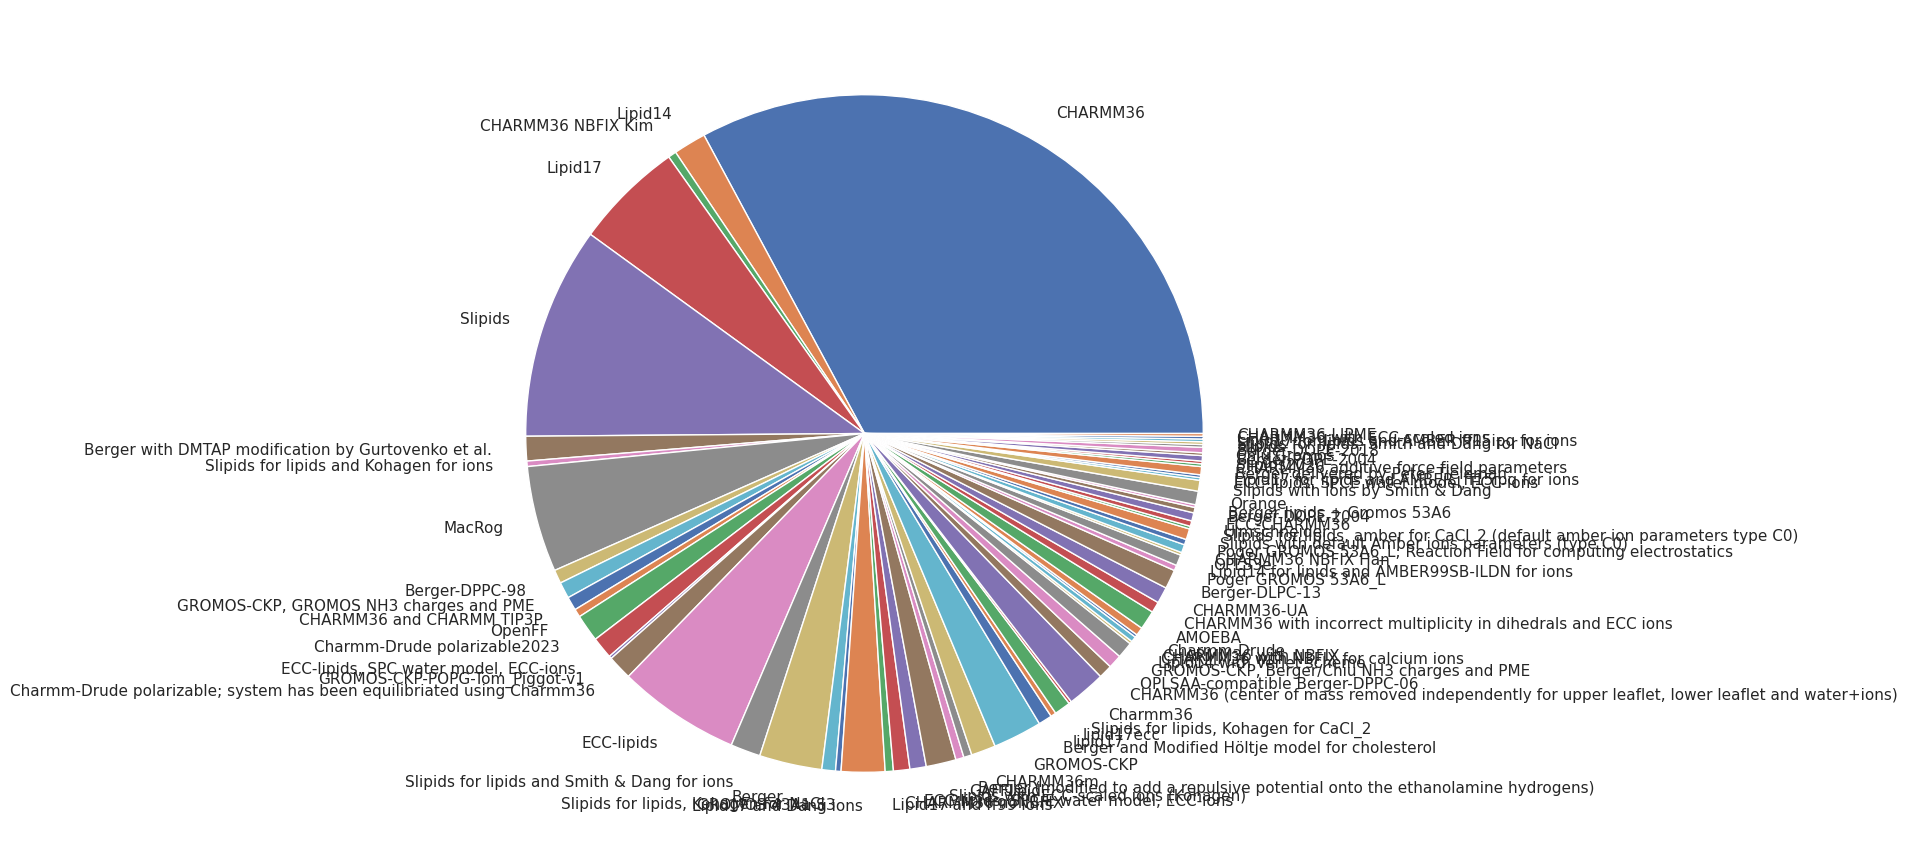

In [7]:

temps = [ system['FF'] for system in systems]
counter = collections.Counter(temps)
plt.pie(counter.values(),labels=counter.keys());

{'OpenFF': 3, 'GROMOS 43A1-S3': 2, 'GAFFlipid': 3, 'Poger': 4, 'OPLS3e': 1, 'Ulmschneider': 2, 'ECC-CHARMM36': 3, 'Orange': 5, 'Chiu Gromos': 1}


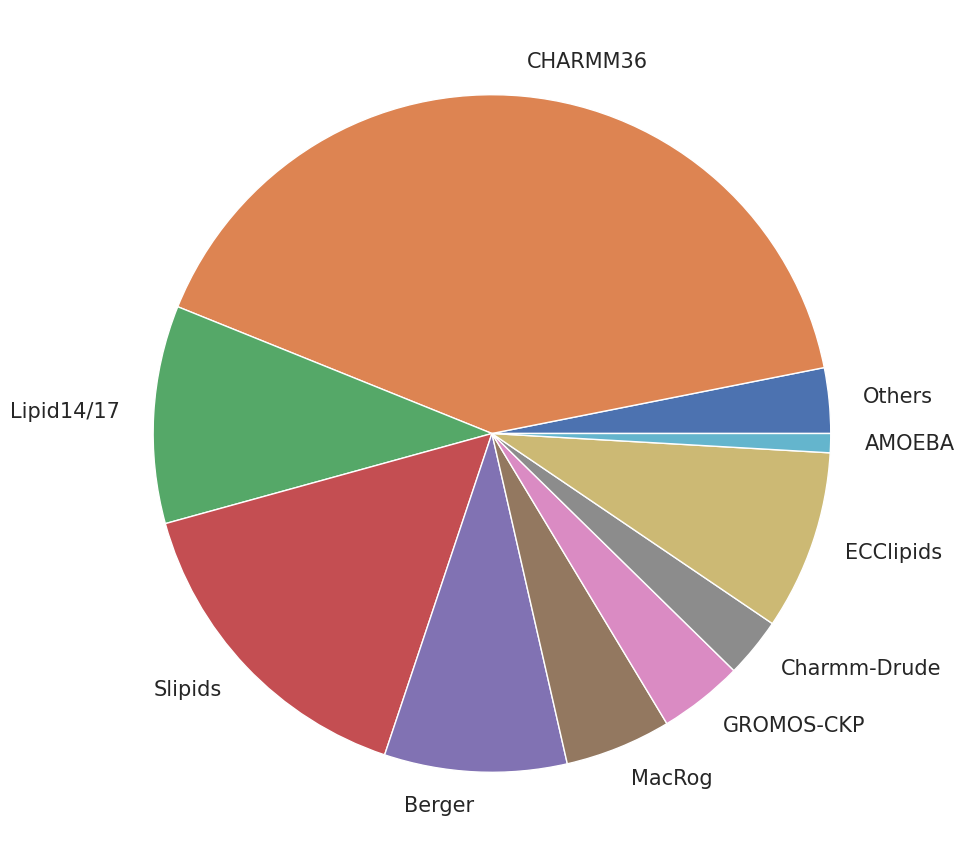

In [8]:
ffs = []

for system in systems:
    try:
        ff = system['FF']
    except:
        print('Force field information missing from' + system['path'])
    
    if 'GROMOS-CKP' in ff or 'gromos-ckp' in ff:
        ffs.append('GROMOS-CKP')
    elif 'Charmm-Drude' in ff:
        ffs.append('Charmm-Drude')
    elif 'Berger' in ff:
        ffs.append('Berger')    
    elif 'Slipids' in ff or 'slipids' in ff:
        ffs.append('Slipids')    
    elif 'lipid17ecc' in ff or 'ECC-lipids' in ff:
        ffs.append('ECClipids')
    elif 'ECC-CHARMM36' in ff:
        ffs.append(ff)
    elif 'CHARMM36' in ff or 'Charmm36' in ff:
        ffs.append('CHARMM36')
    elif 'Lipid14' in ff or 'Lipid17' in ff or 'lipid17' in ff:
        ffs.append('Lipid14/17')
    elif 'Poger' in ff:
        ffs.append('Poger')
    else:
        ffs.append(ff)
    
counter = collections.Counter(ffs)
several = {}
several['Others'] = 0
less = {}
for i in counter:
    if counter[i] > 5:
        several[i] = counter[i]
    else:
        several['Others'] += counter[i] 
        less[i] = counter[i]
#plt.pie(counter.values(),labels=counter.keys(), textprops={'fontsize': 15});
plt.pie(several.values(),labels=several.keys(), textprops={'fontsize': 15});
#plt.savefig('../../../DataBankManuscriptText/Figures/FFpie.pdf', bbox_inches='tight')
print(less)

{'DRPC': 3, 'SDG': 4, 'SAPI24': 1, 'SM16': 5, 'CER': 5, 'DLIPC': 6, 'TLCL_0H': 3, 'SM18': 2, 'PYPC': 3, 'GM1': 3, 'DOG': 4, 'POPI': 2, 'CER180': 1, 'DYPC': 3, 'TOCL': 5, 'SOPC': 6, 'SAPI25': 6, 'DSPC': 2, 'SLiPC': 3, 'SAPI': 1, 'SLPI': 1, 'DEPC': 1, 'PAzePCprot': 1, 'DPPGK': 1, 'SDPE': 4, 'DDOPC': 2, 'PAzePCdeprot': 1, 'DPPG': 2, 'DPPE': 3, 'DCHOL': 2}


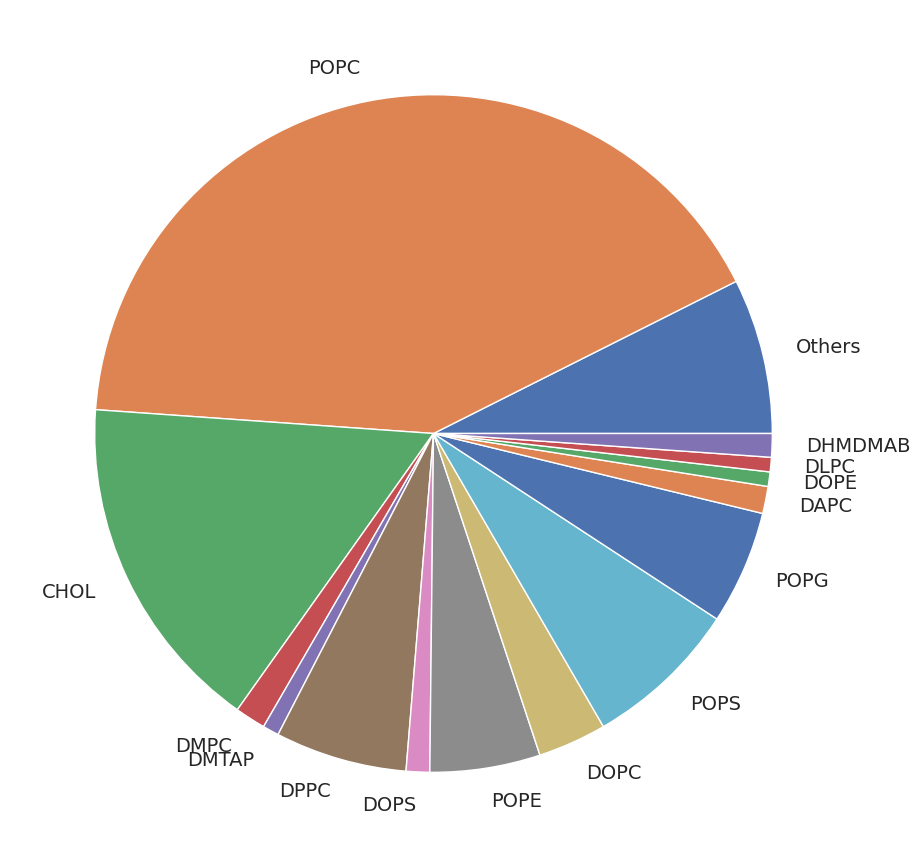

In [9]:
lipids = []
for system in systems:
    for lipid in system['COMPOSITION']:
        if lipid in lipids_dict:
            lipids.append(lipid)
counter = collections.Counter(lipids)
several = {}
several['Others'] = 0
less = {}
for i in counter:
    if counter[i] > 6:
        several[i] = counter[i]
    else:
        several['Others'] += counter[i] 
        less[i] = counter[i]

#plt.figure(figsize=(11,5))
plt.pie(several.values(),labels=several.keys(), textprops={'fontsize': 14});
#plt.savefig('../../../DataBankManuscriptText/Figures/FFlipids.pdf', bbox_inches='tight')
print(less)